# Portfolio Analysis

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

from datetime import datetime                   # Import datetime function
from datetime import timedelta                  # Import timedelta function

from NewForecastTools import MCSimulation       # Import Geometric Brownian Motion (GBM) Monte Carlo simulation model
import user_inputs as func                      # Import the custom user input functions

import json
import seaborn as sns
import numpy as np
import hvplot.pandas

# Import functions from PyPortfolioOpt Module ****
from pypfopt import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import risk_models
from pypfopt import plotting


%matplotlib inline

# Loading settings from the .env file   
Make sure you follow the setup instructions in [README](../README.md), if you haven't already.

In [2]:
# Load .env enviroment variables - these are critical so if any error occurs then stop the script
# If the .env file can't be loaded then print a useful error message and end the script
if not load_dotenv():                                                                                        # Couldn't load the .env file?
    print("Error: could not load .env file. Refer to README.md for instructions on how to set this up.")     #   Print an error message
    exit()                                                                                                   #   Stop the script from proceeding

In [3]:
# Initialise variables needed for the Alpaca Markets API
# Note: The ALPACA_API_KEY and ALPACA_SECRET_KEY are critical for accessing the necessary data. For security reasons these are not initialised in the clear and only fetched from
# the .env file. If we can't fetch them then we warn the user and stop the script.

# Try getting the ALPACA_API_KEY
alpaca_api_key = os.environ.get('ALPACA_API_KEY')        # Fetch the api key from the .env file
if not (alpaca_api_key):                                 # If we couldn't read a valid value...
    print("Error: 'ALPACA_API_KEY' has not been configured correctly in your .env file. Refer to README.md for instructions on how to set this up.")     #    print an error message
    exit()                                               #   Stop the script from proceeding
    
alpaca_secret_key = os.environ.get('ALPACA_SECRET_KEY')  # Fetch the secret key from the .env file
if not (alpaca_secret_key):                              # If we couldn't read a valid value..
    print("Error: 'ALPACA_SECRET_KEY' has not been configured correctly in your .env file. Refer to README.md for instructions on how to set this up.")     #    print an error message
    exit()                                               #   Stop the script from proceeding

# The ALPACA_BASE_URL is not as critical and can be shown in the "clear". We default to the paper-trading environment if it is not configured in the .env file.
alpaca_base_url = os.environ.get('ALPACA_BASE_URL')                                                       # Try to fetch Alpaca's base url from the .env file. 
if not(alpaca_base_url):                                                                                  # If the base url isn't configured in the .env file then...
    alpaca_base_url = "https://paper-api.alpaca.markets"                                                  #   default Alpaca's base url to the paper trading environment, and 
    print(f"Warning: ALPACA_BASE_URL configuration not found in .env file. Defaulting to '{alpaca_base_url}'")     #   print a warning for the user they are using the paper trading environment

alpaca_api_version = "v2"                                # Set the Alpaca API version we will use

# Create the Alpaca API object
alpaca_api = tradeapi.REST(key_id=alpaca_api_key, secret_key=alpaca_secret_key, base_url=alpaca_base_url, api_version=alpaca_api_version)


# Checking the status of your Alpaca Trading Account

In [4]:
# Check status of the Alpaca trading account
account = alpaca_api.get_account()            # Get details of the account (code provided by Alpaca Trade API)
account_status = account.status               # Grab the account status    (code provided by Alpaca Trade API)

print(f"Info: Your Alpaca account status is [{account_status}]")  # Show the current account status
if not (account_status == "ACTIVE"):                             # If the account status is not Active                            
    print("Error: Your account status is not Active. Please activate your account or check your Alpaca keys are correct.")   # Show the error messsage, and a helpful way to resolve
    exit()                                                                                                                   # Stop the script from proceeding

Info: Your Alpaca account status is [ACTIVE]


# Loading up your Portfolio   
**Here is where you tell the program some details of your current portfolio.**   
Please specify in the cell below details of each stock in your portfolio:
* ticker code - also known as the share code or stock code.
* number of shares owned - note if you bought the same share at different time periods you can list these separately.
* buy price - the cost paid for each share.
* purchase date - when you purchased that lot of shares   

Coming soon...importing your portfolio from a CSV file.

In [5]:
# Intialise the makeup of the portfolio.
# *** Nice to have: read the portfolio from a csv or database or a GUI (which can then be saved to a csv or database)

portfolio_list = [
# Set your portfolio contents here...
#                  ** Ticker **  Qty   **  Buy   **  Purchase Date ** 
#                  ** Code   **  Owned **  Price **  YYYY-MM-DD    **
                   [ "GOOG",       123.0,    44.32,    "2021-11-10"   ],
                   [ "GE",      59.0,    43.11,    "2021-11-15"   ],
                   [ "GE",      90.0,    42.67,    "2021-11-16"   ],
                   [ "BAC",     234.0,    12.43,    "2020-07-22"   ],
                   [ "WMT",      115.0,    11.01,    "2020-08-25"   ],
                   [ "WMT",      112.0,    12.15,    "2020-08-28"   ]
]

# Set your preferred currency and base market index code

Although the currency code is not in use at the moment, we use the base market index code to do comparative returns against your portfolio's performance.

In [6]:
currency_code = "USD"            # Set the default currency code which we will be working with.  *** Nice to have: include multi-currency support and currency conversion.
base_market_index_code = "SPY"   # Set the market index code to be used for comparative purposes against the portfolio.  *** Nice to have: user selects from a list

# Here is your portfolio that we will be taking a closer look at

In [7]:
# Create a dataframe with the portfolio composition.
# Column names for the portfolio dataframe
column_names =     ["Ticker Code", "Qty Owned", "Buy Price", "Purchase Date"]       # Ticker Code, Quantity of Shares Owned, Original Purchase Price per share, Purchase Date

portfolio_df = pd.DataFrame(portfolio_list, columns=column_names) # Note we may have multiple entries for the same stock so we can't index the Ticker Code.
portfolio_df

Ticker Code  Qty Owned  Buy Price Purchase Date
0        GOOG      123.0      44.32    2021-11-10
1          GE       59.0      43.11    2021-11-15
2          GE       90.0      42.67    2021-11-16
3         BAC      234.0      12.43    2020-07-22
4         WMT      115.0      11.01    2020-08-25
5         WMT      112.0      12.15    2020-08-28

---   
# Here are a few functions we need   
_Coming soon: we will place these into separate modules and import them so there is less clutter_

## get_latest_price   
This fetches the latest available trading data for the day at close for the specified stock(s).
What's interesting is that it may not be a trading day today, so we need to check up to a few days prior to get the latest available.

In [8]:
# Function: get_latest_price ( ticker_list )
# Purpose: Fetches the latest available trading data for the day at close for the specified stock(s).
# Inputs:
#    ticker_list: list of ticker symbols e.g. ["ABC", "DEF", "GHI"]
# Outputs:
#   returns a data frame as per alpaca_api.get_bars format

def get_latest_price ( tickers ):

    # Set timeframe to "1Day" for Alpaca API
    timeframe = "1Day"

    print(f"Fetching prices for: {ticker_list}")

    # Loop until we find valid trading data or abort after max_attempts attempts
    # Initialise variables
    attempt = 0                       # Initialise the attempt count
    max_attempts = 10                 # Initialise the maximum number of attempts after which we give up
    df_portfolio = pd.DataFrame()     # Intialise the dataframe

    while (attempt < max_attempts) and (len(df_portfolio) == 0):    # Loop until we find an active trading day or abort after the max attempts
        if attempt == 0:
            date_to_fetch = pd.Timestamp.now( tz="America/New_York").normalize()            # Get today's date on the first iteration of the loop
        else:
            date_to_fetch = date_to_fetch + timedelta(days=-1)                              # Decrement the date

        date_to_fetch_iso = date_to_fetch.isoformat()                                       # Convert the date to iso format needed by alpaca_api
        attempt += 1                                                                        # Increment the attempt counter

        # Get current closing prices for SPY and AGG and transform the function's response to a Pandas DataFrame
        df_portfolio = alpaca_api.get_bars( tickers, timeframe, start = date_to_fetch_iso, end = date_to_fetch_iso ).df    # Get the ticker data from alpaca_api

        if len(df_portfolio) == 0:                                                          # If no data returned...
            print(f"Warning: No price information available for {date_to_fetch_iso}")                #   show a warning message with the date

    if len(df_portfolio) == 0:                                                              # Once we exit the loop check if we managed to get ticker data, if not
        print("Error: Could not find data after {max_attempts} attempts" )                         #   show a warning message with the number of max attempts tried
    return df_portfolio

## get_stock_history   
This fetches the historical trading data for the specified stock(s).

In [9]:
# Function: get_stock_history ( ticker_list, start_date, end_date )
# Purpose: Fetches the historical trading data for the specified stock(s).
# Inputs:
#   ticker_list: list of ticker symbols e.g. ["ABC", "DEF", "GHI"]
#   start_date: oldest date in the data range to fetch
#   end_date:   most recent date in the data range to fetch
# Outputs:
#   returns a data frame of historical trading data as per alpaca_api.get_bars format

def get_stock_history ( ticker_list, start_date, end_date ):
    timeframe = "1Day"
    return alpaca_api.get_bars( ticker_list, timeframe, start = start_date, end = end_date ).df

## monte_carlo_simulation_analysis  
This runs a a Monte Carlo simulation analysis and presents various charts

In [10]:
# Run all of the Monte Carlo simulation analysis. 
#   Inputs:
#      input_df (the input dataframe)
#      forecast_years (number of years to forecast)
#      type_of_holding (list of what type of security class the corresponding weighting is)
#      initial_investment (initial investment amount )
#
def monte_carlo_simulation_analysis( input_df, forecast_years, weightings, initial_investment ):
    
    # Run the Monte Carlo simulation
    MC_sim = MCSimulation(
        portfolio_data = input_df,
        weights = weightings,
        num_simulation = 500,
        num_trading_days = 252 * forecast_years
    )
    
    # Printing the simulation input data (for debugging if required)
    # print("Daily returns")
    # print(MC_sim.daily_returns.head(), "\n")
    
    # Run a Monte Carlo simulation to forecast cumulative returns
    MC_sim.calc_cumulative_return()
    
    # Plot simulation outcomes
    line_plot = MC_sim.plot_simulation()
    #line_plot.title = "Mean, median, and 95% confidence interval of the simulated stock trajectories"
    
    display(line_plot)

    # Plot probability distribution and confidence intervals
    dist_plot = MC_sim.plot_distribution()
    #dist_plot.title = "Probability distribution and confidence intervals"
    display(dist_plot)
    
      
    # Fetch summary statistics from the Monte Carlo simulation results
    cr_table = MC_sim.summarize_cumulative_return()

    # Print summary statistics
    print("Summary statistics")
    print(cr_table)
    print()
    
    # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of the initial investment
    ci_lower = round(cr_table["95% CI Lower"]*initial_investment,2)
    ci_upper = round(cr_table["95% CI Upper"]*initial_investment,2)

    # Print a summary of input parameters and the confidence indications
    print ("Confidence Interval Analysis")
    # Print results
    print(f"There is a 95% chance that an initial investment of ${initial_investment:0,.2f} in the portfolio"
          f" over the next {forecast_years} years will end within in the range of"
          f" ${ci_lower:0,.2f} and ${ci_upper:0,.2f}")   

---

# Current Value of Your Portfolio   
In this part you will see:   
1. The latest trading data for each stock in your portfolio
1. Your aggregated holding showing the total of each stock held and the average purchase price.

In [11]:
# Get current prices of each stock in the portfolio
ticker_list = portfolio_df["Ticker Code"].unique()                       # First we will create a ticker list without duplicates from your portofolio
current_prices = get_latest_price ( ticker_list ).set_index("symbol")    # Now fetch the latest prices of each stock from Alpaca

Fetching prices for: ['GOOG' 'GE' 'BAC' 'WMT']


### Here is the latest market trading data for stocks in your portfolio

In [12]:
# Present the latest trading data
current_prices

close     high      low  trade_count    open    volume        vwap
symbol                                                                     
BAC      26.31   26.940   26.240       211696   26.80  62058408   26.454937
GE      106.08  107.240  105.530        69783  106.70   7753161  106.212605
GOOG    136.74  139.040  136.245       247091  138.59  24970264  137.299802
WMT     158.76  161.105  158.710        74614  160.83   5019082  159.507370

## Let's run some calculations to see where you are at with the portfolio

In [13]:
# Create a copy of the portfolio data frame as we will be aggregating and adding some extra columns
portfolio_current_stats = portfolio_df.copy()    # Copy the dataframe
# Add new columns to the dataframe and initialise
portfolio_current_stats['Current Value'] = 0.0   # Add current value column and initialise values to 0
portfolio_current_stats['Purchase Value'] = 0.0  # Add purchase value column and initialise values to 0
portfolio_current_stats['Profit'] = 0.0          # Add profit column and initialise values to 0

# Next we merge the closing price from the current prices dataframe
portfolio_current_stats = portfolio_current_stats.merge(current_prices["close"],how="outer",left_on=['Ticker Code'],right_on=["symbol"])

In [14]:
# Perform calculations
# Updating the current closing price
portfolio_current_stats['Current Value'] = portfolio_current_stats['close'] * portfolio_current_stats['Qty Owned']                        # Calculate the Current value by multiplying the close price by the quantity of each share owned 
# Here we calculate the total cost of each stock...
portfolio_current_stats['Purchase Value'] = portfolio_current_stats["Buy Price"] * portfolio_current_stats['Qty Owned']      # Calculate the Purchase value by multiplying the original (average) buy price by the quantity of each share owned
# Now we can work out your profit for each position...
portfolio_current_stats['Profit'] = portfolio_current_stats['Current Value'] - portfolio_current_stats['Purchase Value']         # Calculate the Profit subtracting the current value from the original cost

In [15]:
# Determine the current total value and total profit / loss
total_portfolio_value = portfolio_current_stats["Current Value"].sum()               # Total the current value column
total_portfolio_profit = portfolio_current_stats["Profit"].sum()                     # Total the profit column
total_portfolio_profit_pct = total_portfolio_profit / total_portfolio_value * 100    # Work out the total percentage return

In [16]:
# Determine the portfolio weighting of each stock/ticker.
portfolio_current_stats['Weighting'] = 0.0   # Add a new column for weighting

# Calculate the stock weighting as a percentage of the total porfolio value
portfolio_current_stats['Weighting'] = portfolio_current_stats['Current Value'] / total_portfolio_value

## Your portfolio - current snapshot

In [17]:
#portfolio_current_stats['Weighting'] # Show the results
portfolio_current_stats.head(len(portfolio_current_stats)) # Let's take a look (show all records)

Ticker Code  Qty Owned  Buy Price Purchase Date  Current Value  \
0        GOOG      123.0      44.32    2021-11-10       16819.02   
1          GE       59.0      43.11    2021-11-15        6258.72   
2          GE       90.0      42.67    2021-11-16        9547.20   
3         BAC      234.0      12.43    2020-07-22        6156.54   
4         WMT      115.0      11.01    2020-08-25       18257.40   
5         WMT      112.0      12.15    2020-08-28       17781.12   

   Purchase Value    Profit   close  Weighting  
0         5451.36  11367.66  136.74   0.224793  
1         2543.49   3715.23  106.08   0.083650  
2         3840.30   5706.90  106.08   0.127602  
3         2908.62   3247.92   26.31   0.082285  
4         1266.15  16991.25  158.76   0.244018  
5         1360.80  16420.32  158.76   0.237652

The above table shows the individual profit / loss of each of your stocks, and the weighting   
_Coming soon...showing the year-on-year percentage return   
Coming soon...plotting a historical chart_ 

## Next we will do some aggregations to give you an overall perspective 

In [18]:
# ...then we aggregate (sum) the unit quantities and cost.
# Note we are going round about so we can eventually calculate a weighted average cost across any multiple holdings of the same stock purchased at different times
portfolio_aggregated_stats = portfolio_current_stats[["Ticker Code","Qty Owned", "Purchase Value", "Current Value", "Profit", "Weighting"]].groupby("Ticker Code").sum().copy()
# ...so we can determine the (weighted) average buy price per share
portfolio_aggregated_stats['Avg Buy Price'] = 0.0   # Add average buy price (being the weighted average) column and initialise values to 0

portfolio_aggregated_stats["Avg Buy Price"] = portfolio_aggregated_stats["Purchase Value"] / portfolio_aggregated_stats["Qty Owned"] # Calculate Average Price = Total Purchase Cost divided by Shares owned
portfolio_aggregated_stats # Let's see what it looks like

Qty Owned  Purchase Value  Current Value    Profit  Weighting  \
Ticker Code                                                                  
BAC              234.0         2908.62        6156.54   3247.92   0.082285   
GE               149.0         6383.79       15805.92   9422.13   0.211253   
GOOG             123.0         5451.36       16819.02  11367.66   0.224793   
WMT              227.0         2626.95       36038.52  33411.57   0.481670   

             Avg Buy Price  
Ticker Code                 
BAC              12.430000  
GE               42.844228  
GOOG             44.320000  
WMT              11.572467

**Aggregated Data**. The table above shows for each Ticker Code the current total value, profit/loss and the average cost per share.**

## Here is a visual showing the profit of each stock

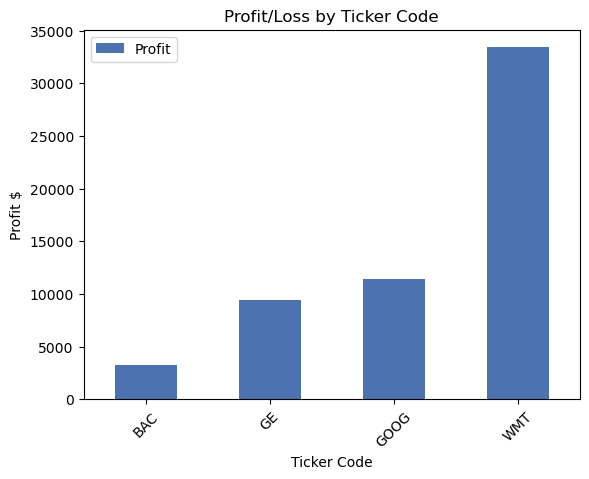

In [19]:
# Present the Profit column from the aggregated dataframe
profit_by_ticker_code_plot = portfolio_aggregated_stats.plot.bar(title = "Profit/Loss by Ticker Code",  y="Profit", xlabel="Ticker Code", ylabel="Profit $", rot=45 ) # show the bar chart

## Overall, let's see how your portfolio is doing

_Coming soon: year on year performance comparison_

In [20]:
# Show the output
print("Summary Snapshot")
print(f"Total value:       ${total_portfolio_value:0,.2f}")
print(f"Total profit/loss: ${total_portfolio_profit:0,.2f}")
print(f"Percentage return:      {total_portfolio_profit_pct:0,.2f}%")

Summary Snapshot
Total value:       $74,820.00
Total profit/loss: $57,449.28
Percentage return:      76.78%


---

# Weightings

## Do you need to rebalance your portfolio?   
Here is a visual showing the current stock weightings in your portfolio. Later on you can run simulations using different weightings, and also recommendations from EfficientFrontier

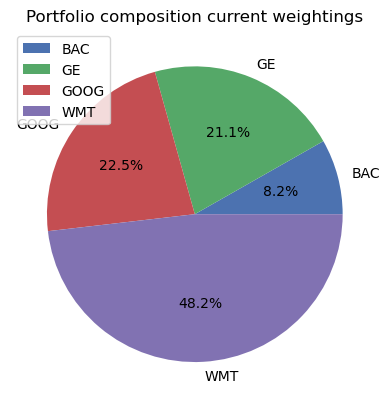

In [21]:
# Plot porfolio composition into a pie chart
fig1 = portfolio_aggregated_stats.plot.pie( title = "Portfolio composition current weightings", y="Current Value", ylabel='', autopct = "%1.1f%%" ) 

# Let's set the Desired Portfolio Weighting
**Set the Desired Weighting as required.**   
Note the order in the list below corresponds to the `symbol` order above 

In [22]:
# Showing the stock ticker order  
ticker_list_desired = portfolio_aggregated_stats.index.to_list() 
ticker_list_desired

['BAC', 'GE', 'GOOG', 'WMT']

In [23]:
# Showing the current weightings of your portfolio
current_weightings = portfolio_aggregated_stats["Weighting"].to_list()
current_weightings

[0.08228468323977546,
 0.21125260625501202,
 0.22479310344827585,
 0.4816696070569366]

Above are the current weightings. What might be your preferred weighting? Set these below

In [24]:
# Setting the preferred weightings. Make sure the total adds up to 1
# Example: desired_weighting = [0.0831947005551773, 0.21014882929316867, 0.22538425841123472, 0.48127221174041934]
desired_weighting = [0.40, 0.25, 0.15, 0.20] 
if sum(desired_weighting) != 1:                            # Check desired_weighting adds up to 1.0
    print("Warning: desired_weighting does not equal 1.0") # if not show a warning

In [25]:
# Generating a dataframe to with ticker codes and your desired weighting so we can show a pie chart later
fig2_df = pd.DataFrame(desired_weighting, index=ticker_list_desired, columns=["Weightings"])
display(fig2_df)

Weightings
BAC         0.40
GE          0.25
GOOG        0.15
WMT         0.20

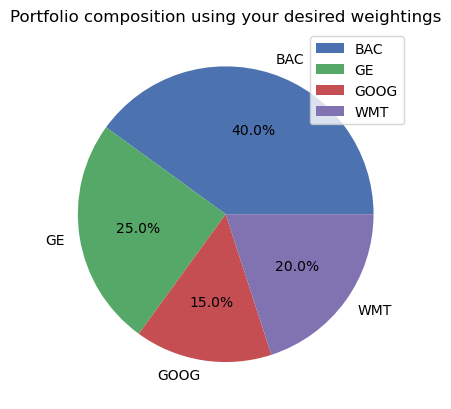

In [26]:
# Plot desired porfolio composition into a pie chart

fig2 = fig2_df.plot.pie( title = "Portfolio composition using your desired weightings", y="Weightings", ylabel='', autopct = "%1.1f%%" )

_Coming soon: graphical user interface slider to change the weightings_

---

# Historical Analysis
Select a time period for historical data to be retrieved and analysed.   
_Coming soon: graphical user interface calendar widget, slider, or drop down menu to select a time period_

In [27]:
# Set how many years of historical data you want to fetch here below. 
years_of_historical_data = 15  # Note: the more data the better, but there is a trade off with performance and memory capacity. Be careful!

In [28]:
# Automatically set the time period to retrieve historical trading data from today
timezone = "America/New_York"  #  Note: It is recommended that you leave this value as "America/New_York". Sets the timezone to be used in the date / time functions.
end_date = pd.Timestamp.now( tz=timezone ).normalize().isoformat()                                                         # Get today's date
start_date = (pd.Timestamp.now( tz=timezone ).normalize() + timedelta(days=-365 * years_of_historical_data)).isoformat()   # Subtract the number of years from today's date to get the start date
print(f"Time frame: {start_date} - {end_date}" )

Time frame: 2008-10-25T00:00:00-04:00 - 2023-10-22T00:00:00-04:00


### Overridding the most recent data as we don't yet support stock splits
The following cell can still be kept once stock-split support is implemented in case you want a specific time period

In [29]:
# Manually set a specific time period manually. You can comment this cell out if you just want the latest data using the previous cell.
start_date = pd.Timestamp('2016-05-01', tz=timezone).isoformat()    # Set the historical data time period start
end_date   = pd.Timestamp('2021-05-01', tz=timezone).isoformat()    # Set the historical data time period end
print(f"Time frame: {start_date} - {end_date}" )

Time frame: 2016-05-01T00:00:00-04:00 - 2021-05-01T00:00:00-04:00


In [30]:
# Show which time frame is actually being used
print(f"Using time frame {start_date} - {end_date} to fetch historical data.")

Using time frame 2016-05-01T00:00:00-04:00 - 2021-05-01T00:00:00-04:00 to fetch historical data.


In [31]:
# Fetch the historical trading data
all_historical_data_df = get_stock_history( ticker_list, start_date, end_date )
all_historical_data_df

close     high      low  trade_count    open  \
timestamp                                                                  
2016-05-02 04:00:00+00:00   14.77   14.780   14.400       108588   14.58   
2016-05-03 04:00:00+00:00   14.36   14.510   14.150       164274   14.51   
2016-05-04 04:00:00+00:00   14.13   14.270   14.000       149008   14.09   
2016-05-05 04:00:00+00:00   14.05   14.320   14.000       116929   14.15   
2016-05-06 04:00:00+00:00   14.11   14.140   13.800       117009   13.83   
...                           ...      ...      ...          ...     ...   
2021-04-26 04:00:00+00:00  137.91  140.000  137.640        90121  139.91   
2021-04-27 04:00:00+00:00  138.38  138.945  137.550        63567  138.00   
2021-04-28 04:00:00+00:00  137.89  138.590  137.865        59234  138.35   
2021-04-29 04:00:00+00:00  139.63  140.000  137.900        74086  137.90   
2021-04-30 04:00:00+00:00  139.91  139.990  139.110        68956  139.71   

                              volume        vwap symbol  
timestamp                                                
2016-05-02 04:00:00+00:00   72897550   14.662741    BAC  
2016-05-03 04:00:00+00:00  113510371   14.327426    BAC  
2016-05-04 04:00:00+00:00  103132467   14.105529    BAC  
2016-05-05 04:00:00+00:00   75700788   14.111568    BAC  
2016-05-06 04:00:00+00:00   79572928   14.015944    BAC  
...                              ...         ...    ...  
2021-04-26 04:00:00+00:00    8132687  138.192355    WMT  
2021-04-27 04:00:00+00:00    5754812  138.479346    WMT  
2021-04-28 04:00:00+00:00    5246045  138.143433    WMT  
2021-04-29 04:00:00+00:00    7001722  139.462541    WMT  
2021-04-30 04:00:00+00:00    7878782  139.736453    WMT  

[5036 rows x 8 columns]

## Let's see what date the lastest available trading data is from

In [32]:
max(all_historical_data_df.index) # Show the most recent date

Timestamp('2021-04-30 04:00:00+0000', tz='UTC')

Coming soon...plotting historical data using [MPL Finance module](https://github.com/matplotlib/mplfinance) to present price (line) and volume (bar) on same plot, candlesticks and moving averages

---

## Rearranging the data into a useable format

In [33]:
# Create a new dataframe in the required format for PyPortfolioOpt which is:
#  date/time ticker1 ticker2 etc
all_historical_ppo_df = all_historical_data_df.pivot(values="close", columns="symbol").copy()

In [34]:
# Let's see what the new data structure looks like
all_historical_ppo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2016-05-02 04:00:00+00:00 to 2021-04-30 04:00:00+00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BAC     1259 non-null   float64
 1   GE      1259 non-null   float64
 2   GOOG    1259 non-null   float64
 3   WMT     1259 non-null   float64
dtypes: float64(4)
memory usage: 49.2 KB


In [35]:
# Let's see what the actual data looks like
all_historical_ppo_df

symbol                       BAC     GE     GOOG     WMT
timestamp                                               
2016-05-02 04:00:00+00:00  14.77  30.89   698.21   67.59
2016-05-03 04:00:00+00:00  14.36  30.63   692.36   67.00
2016-05-04 04:00:00+00:00  14.13  30.07   695.70   67.19
2016-05-05 04:00:00+00:00  14.05  29.89   701.43   67.21
2016-05-06 04:00:00+00:00  14.11  30.12   711.12   68.25
...                          ...    ...      ...     ...
2021-04-26 04:00:00+00:00  39.41  13.57  2326.74  137.91
2021-04-27 04:00:00+00:00  39.88  13.49  2307.12  138.38
2021-04-28 04:00:00+00:00  40.03  13.20  2379.91  137.89
2021-04-29 04:00:00+00:00  41.11  13.21  2429.89  139.63
2021-04-30 04:00:00+00:00  40.53  13.12  2410.12  139.91

[1259 rows x 4 columns]

In [36]:
## Better still let's plot the historical data

In [37]:
hist_plot = all_historical_ppo_df.hvplot.line(
     xlabel="Date",                                     # Label the x axis
     ylabel="Closing price per share",                  # Label the y axis
     height=500,                                        # Set the image height
     width=800                                          # Set the image width
).opts( yformatter='%.0f',                              # Set numbers to standard notation
        title="Historical Closing Prices")              # Set the Title

hist_plot                                               # Display the plot

:NdOverlay   [symbol]
   :Curve   [timestamp]   (value)

In case you included GOOG (Alphabet Inc., also known as Google) in your portfolio and selected a date that includes July 2022, you will notice an incredible drop in July 2022. No need to panic as this relates to a 20:1 stock split. Check out [Investopedia](https://www.investopedia.com/google-alphabet-q4-fy2021-earnings-report-recap-5217789) for more details.

Coming soon...adjustments for stock splits   

---

# Mean-Variance Optimisation Analysis   
Here we use the [PyPortfolioOpt module](https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html?#mean-variance-optimization) to do some advanced analysis of your portfolio.

## Calculating the covariance matrix

In [38]:
# Calculating the covariance matrix based on our loaded pricing data and a frequency of 1 year
cov_matrix = risk_models.sample_cov(all_historical_ppo_df, frequency=252)
cov_matrix

symbol       BAC        GE      GOOG       WMT
symbol                                        
BAC     0.119354  0.074994  0.043851  0.018574
GE      0.074994  0.161521  0.032383  0.011309
GOOG    0.043851  0.032383  0.070977  0.018393
WMT     0.018574  0.011309  0.018393  0.050609

Text(0.5, 1.0, 'Covariance matrix of your portfolio')

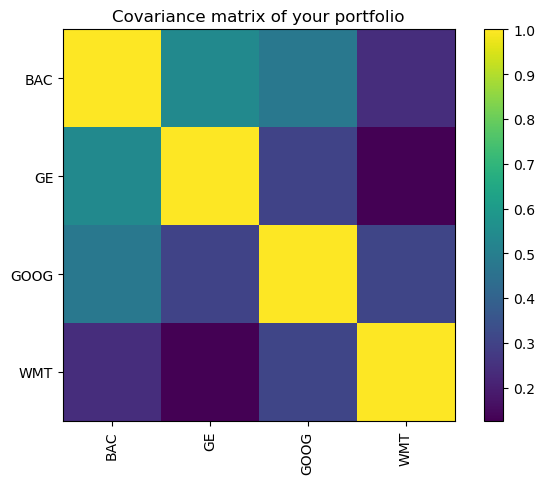

In [39]:
# Plotting the covariance matrix
ax = plotting.plot_covariance(cov_matrix, plot_correlation=True);  # Plot the covariance matrix and return a handle so we can...
ax.set_title("Covariance matrix of your portfolio")                # ...set the title

The diagram above shows the degree of covariance of one stock to another. Covariance measures the directional relationship between the returns on two assets. A positive covariance means asset returns move together, while a negative covariance means they move inversely. Definition source [Investopedia](https://www.investopedia.com/terms/c/covariance.asp)

Ignoring the bright diagonal, any other bright colours show a higher degree of covariance.

In [40]:
# Calculate expected returns
mu = mean_historical_return(all_historical_ppo_df)              # Mu (mean):  annualised mean (daily) return for each asset
mean_hist_rets_mu = mu
print(mean_hist_rets_mu) # show the result of expected returns
# Code source: https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html

symbol
BAC     0.224105
GE     -0.157626
GOOG    0.281686
WMT     0.156894
dtype: float64


### Table above - showing the expected returns

In [41]:
# Calculate Covariance Shrinkage
S = CovarianceShrinkage(all_historical_ppo_df).ledoit_wolf()     # Sigma (sum): of the Ledoit Wolf shrinkage estimate of the covariance matrix
total_shrinkage_s = S
total_shrinkage_s  # show the result
# Code source: https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html

symbol       BAC        GE      GOOG       WMT
symbol                                        
BAC     0.118657  0.072521  0.042406  0.017962
GE      0.072521  0.159433  0.031315  0.010936
GOOG    0.042406  0.031315  0.071874  0.017787
WMT     0.017962  0.010936  0.017787  0.052178

### Table above - showing the risk covariance model

## What Is the Efficient Frontier?
The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return.

Citation: [Investopedia](https://www.investopedia.com/terms/e/efficientfrontier.asp)

In [42]:
# Determine the maximum sharpe ratio (portfolio's return in excess of the risk-free rate, per unit risk (standard deviation / volatility)
risk_free_rate = 0.02  # You can set the risk-free rate of borrowing/lending here. For example a value of 0.02 represents 2%. The period of the risk-free rate should correspond to the frequency of expected returns.

# Create a new EfficientFrontier object as the previous one has had vairable substitution and is no longer useable
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))           # restrict the weight bounds from 0 to a maximum of 1. You can use -1 instead of zero if you are comfortable with "shorting" any stock
# Maximise the Sharpe Ratio. The result is also referred to as the tangency portfolio, as it is the portfolio for which the capital market line is tangent to the efficient frontier.
raw_weights = ef.max_sharpe( risk_free_rate )                                       
# Code source: https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html

In [43]:
# Present the weights
cleaned_weights = ef.clean_weights()  # clean the raw weights, setting any weights whose absolute values are below the cutoff to zero, and rounding the rest.
# You can save the weights to a csv file by uncommenting the following line
# ef2.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
# Code source: https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html

OrderedDict([('BAC', 0.08485), ('GE', 0.0), ('GOOG', 0.62019), ('WMT', 0.29496)])


In [44]:
# Provide the projected performance
optimal_weights_w = ef.portfolio_performance(verbose=True)

Expected annual return: 24.0%
Annual volatility: 21.2%
Sharpe Ratio: 1.04


## If you have spare cash, here is a *SUGGESTION* of how many shares of each asset you should purchase already in your portfolio.

In [45]:
# Set the amount of spare cash you have here
spare_cash_amount = 20000

In [46]:
# Working out the discrete allocation
latest_prices = get_latest_prices(all_historical_ppo_df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=spare_cash_amount)       # Call DiscreteAllocation 
allocation, leftover = da.lp_portfolio()                                                               # Get the suggested allocation and leftover cash

In [47]:
# Convert the dictionary into a list and then into a dataframe for plotting
allocation_df = pd.DataFrame(list(allocation.items()), columns=["Stock","Allocation(EF)"]).set_index("Stock")
allocation_df # show the suggestions

Allocation(EF)
Stock                
BAC                42
GOOG                5
WMT                43

The table above is showing a suggested makeup of your portfolio from the stock information we currently have.

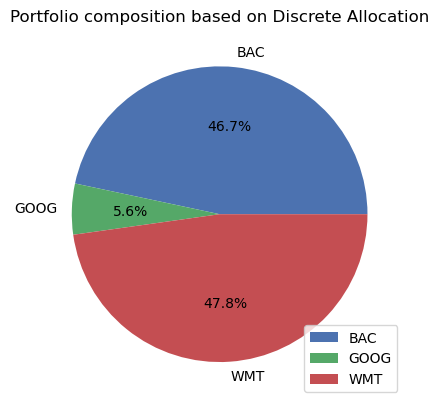

In [48]:
# Plot the suggested allocation
fig3 = allocation_df.plot.pie( title = "Portfolio composition based on Discrete Allocation", y="Allocation(EF)", ylabel='', xlabel="Stock", autopct = "%1.1f%%" )

---

C:\Users\brusi\Anaconda3\envs\dev\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


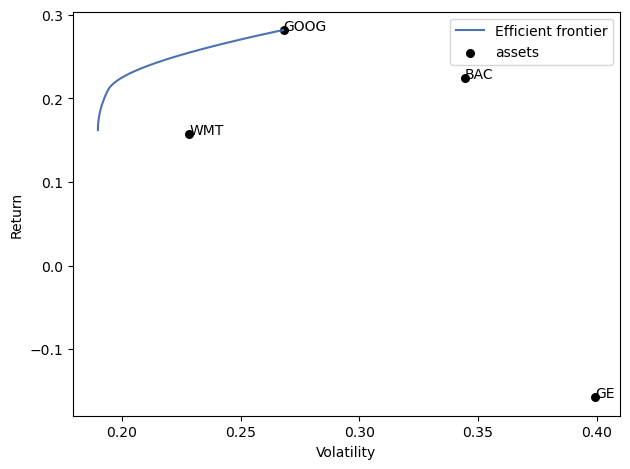

In [49]:
# Recalculate the efficient frontier for plotting
ef2 = EfficientFrontier(mu, S, weight_bounds=(0, 1))                 # Create the EfficientFrontier object 
ef2_ret = plotting.plot_efficient_frontier(ef2, points=500, show_assets = True, show_tickers=True, showfig= True)
# Coming soon...adding constraints e.g. a single or combination of stocks can't be more than x% of the total portfolio composition

### Figure above - Efficient Frontier plot of your portfolio

# Portfolio outlook based on your current stock's weightings

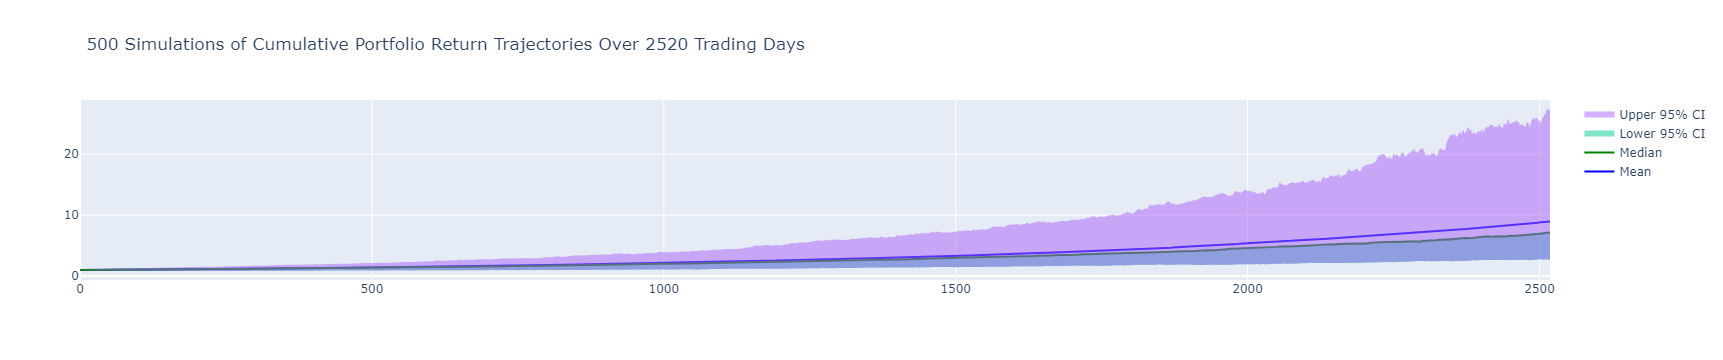

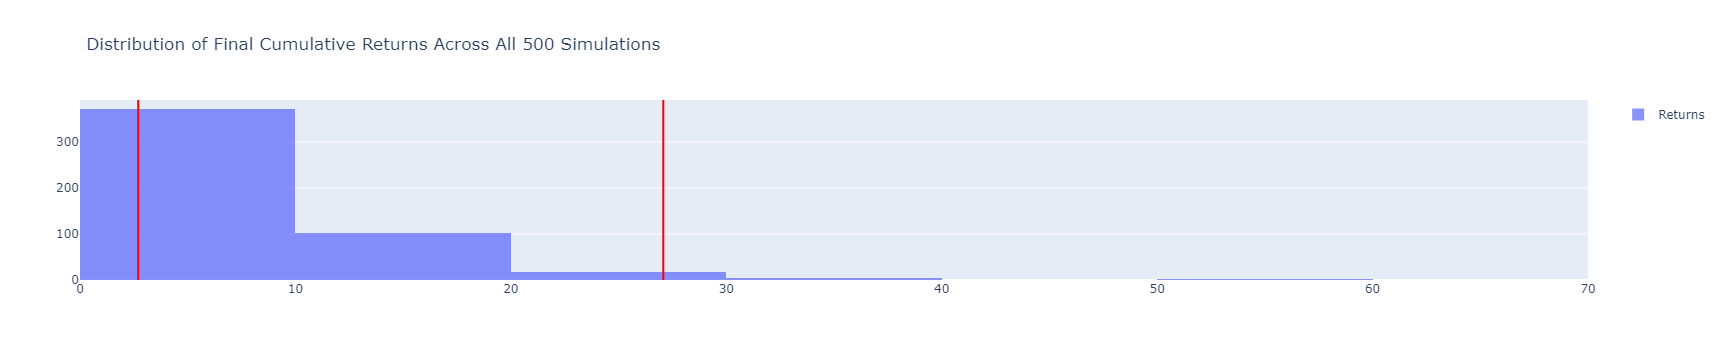

Summary statistics
count           500.000000
mean              8.936561
std               6.906335
min               1.148555
25%               5.065481
50%               7.062909
75%              10.179448
max              66.749260
95% CI Lower      2.703054
95% CI Upper     27.074669
Name: 2518, dtype: float64

Confidence Interval Analysis
There is a 95% chance that an initial investment of $10,000.00 in the portfolio over the next 10 years will end within in the range of $27,030.54 and $270,746.69


In [50]:
# Run a Monte Carlo Simulation using the portfolio's current weighting distribution
monte_carlo_simulation_analysis( all_historical_data_df, 10, current_weightings, 10000 )
#   Inputs:
#      input_df (the input dataframe)
#      forecast_years (number of years to forecast)
#      weightings (list of weightings)
#      initial_investment (initial investment amount )

## Portfolio outlook based on your revised (desired) stock weightings

In [51]:
suggested_weighting = list(cleaned_weights.values()) # Extract the weighting into a list

In [52]:
# WORK IN PROGRESS
# sugg_weighting_df = pd.DataFrame(suggested_weighting, index=ticker_list_desired, columns=["Weightings"])
# display(sugg_weighting_df)
# sugg_weighting_df_fig = sugg_weighting_df.plot.pie( title = "Portfolio composition using your desired weightings", y="Weightings", ylabel='', autopct = "%1.1f%%" )

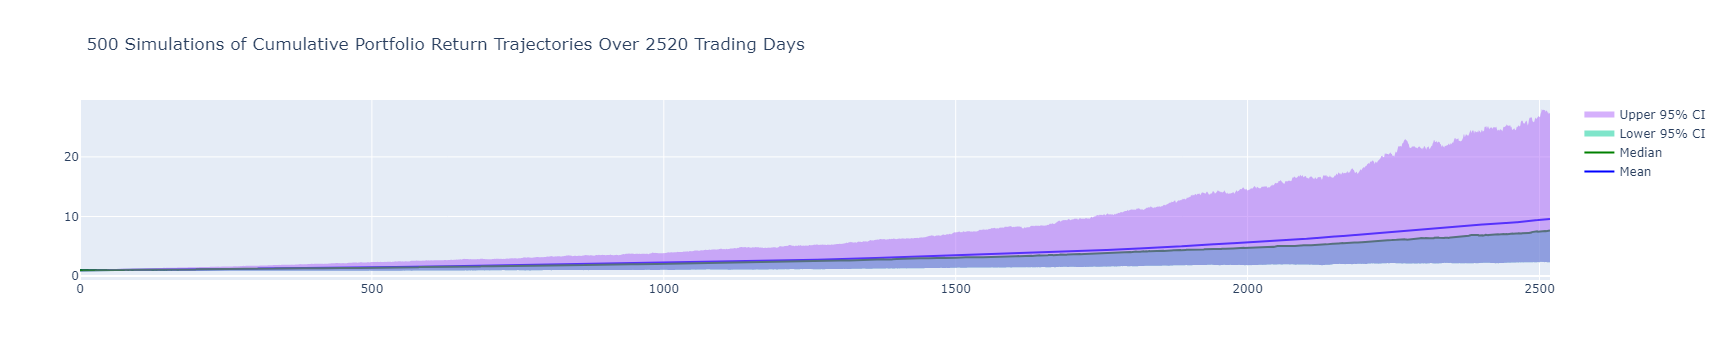

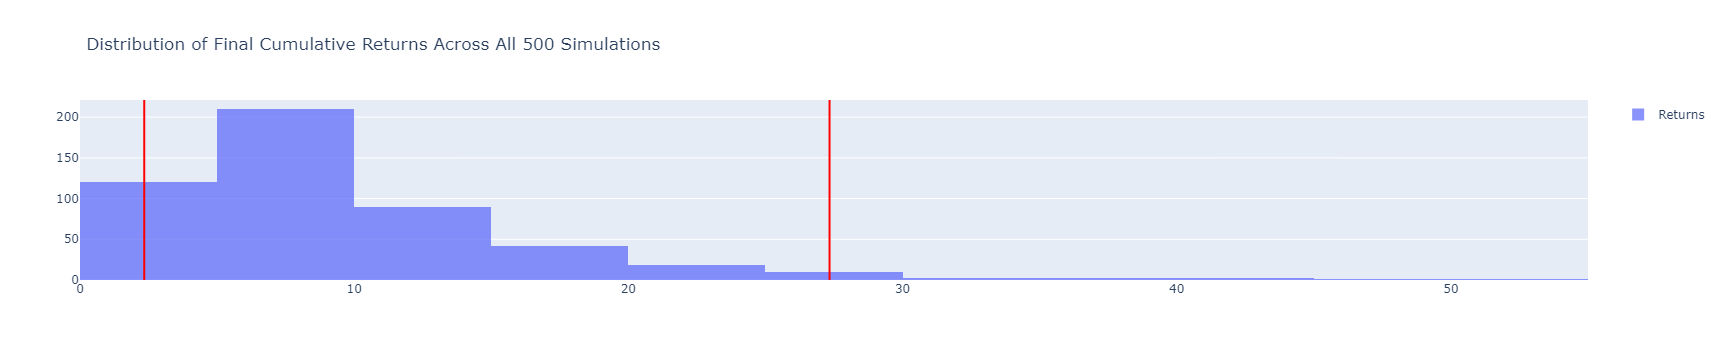

Summary statistics
count           500.000000
mean              9.592056
std               6.859767
min               1.168548
25%               5.077413
50%               7.656760
75%              12.195538
max              50.981048
95% CI Lower      2.343066
95% CI Upper     27.337254
Name: 2518, dtype: float64

Confidence Interval Analysis
There is a 95% chance that an initial investment of $10,000.00 in the portfolio over the next 10 years will end within in the range of $23,430.66 and $273,372.54


In [53]:
# Run a Monte Carlo Simulation using the portfolio's current weighting distribution
monte_carlo_simulation_analysis( all_historical_data_df, 10, desired_weighting, 10000 )
#   Inputs:
#      input_df (the input dataframe)
#      forecast_years (number of years to forecast)
#      weightings (list of weightings)
#      initial_investment (initial investment amount )

# Presenting further analysis and views

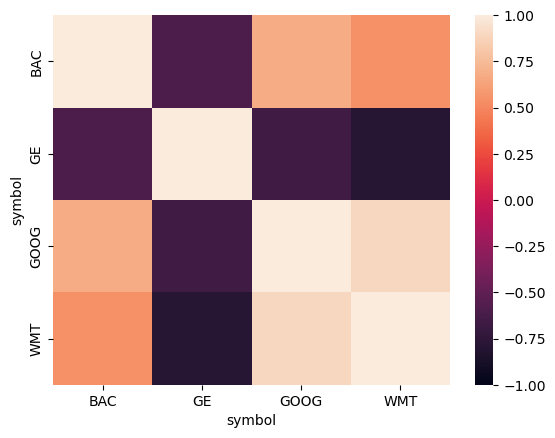

In [54]:
# Calculate and plot the correlation
portfolio_correlation = all_historical_ppo_df.corr()
portfolio_correlation
# Display the correlation matrix
sns.heatmap(portfolio_correlation, vmin=-1, vmax=1);

### Heat map of stock correlation in a different colour scheme

In [55]:
# Recalculate the current weighting
weighting_list = portfolio_current_stats["Weighting"].tolist()
weighting_list

[0.22479310344827585,
 0.08365036086607859,
 0.12760224538893344,
 0.08228468323977546,
 0.24401764234161985,
 0.23765196471531674]

In [56]:
# Create a dataframe with daily percentage change
portfolio_daily_returns = all_historical_ppo_df.pct_change().dropna()
portfolio_daily_returns

symbol                          BAC        GE      GOOG       WMT
timestamp                                                        
2016-05-03 04:00:00+00:00 -0.027759 -0.008417 -0.008379 -0.008729
2016-05-04 04:00:00+00:00 -0.016017 -0.018283  0.004824  0.002836
2016-05-05 04:00:00+00:00 -0.005662 -0.005986  0.008236  0.000298
2016-05-06 04:00:00+00:00  0.004270  0.007695  0.013815  0.015474
2016-05-09 04:00:00+00:00 -0.008505 -0.008300  0.002503  0.010256
...                             ...       ...       ...       ...
2021-04-26 04:00:00+00:00  0.005870  0.001476  0.004941 -0.014224
2021-04-27 04:00:00+00:00  0.011926 -0.005895 -0.008432  0.003408
2021-04-28 04:00:00+00:00  0.003761 -0.021497  0.031550 -0.003541
2021-04-29 04:00:00+00:00  0.026980  0.000758  0.021001  0.012619
2021-04-30 04:00:00+00:00 -0.014108 -0.006813 -0.008136  0.002005

[1258 rows x 4 columns]

In [57]:
# Set weights
# Calculate portfolio return
custom_port_daily_returns_dot = portfolio_daily_returns.dot(current_weightings) 
custom_port_daily_returns_dot_df = custom_port_daily_returns_dot.to_frame()     # Convert the daily returns to a dataframe for use later
custom_port_daily_returns_dot_df = custom_port_daily_returns_dot_df.rename(columns={0: "Portfolio Returns"})  # Rename the index column to something sensible

In [58]:
custom_port_daily_returns_dot_df

Portfolio Returns
timestamp                                   
2016-05-03 04:00:00+00:00          -0.010150
2016-05-04 04:00:00+00:00          -0.002730
2016-05-05 04:00:00+00:00           0.000264
2016-05-06 04:00:00+00:00           0.012536
2016-05-09 04:00:00+00:00           0.003050
...                                      ...
2021-04-26 04:00:00+00:00          -0.004946
2021-04-27 04:00:00+00:00          -0.000518
2021-04-28 04:00:00+00:00           0.001155
2021-04-29 04:00:00+00:00           0.013179
2021-04-30 04:00:00+00:00          -0.003463

[1258 rows x 1 columns]

## Fetching Benchmark Stock price details

In [59]:
# Beta of portfolio

benchmark_historical_df = get_stock_history( base_market_index_code, start_date, end_date )  # Retrieve the benchmark index historical data for the same period as the rest of the portfolio

In [60]:
benchmark_historical_df

close    high       low  trade_count    open  \
timestamp                                                                    
2016-05-02 04:00:00+00:00  207.9700  208.18  206.4100       263586  206.92   
2016-05-03 04:00:00+00:00  206.1592  206.80  205.2800       377523  206.52   
2016-05-04 04:00:00+00:00  205.0100  205.85  204.4200       345266  204.99   
2016-05-05 04:00:00+00:00  204.9700  205.98  204.4700       280626  205.56   
2016-05-06 04:00:00+00:00  205.7200  205.77  203.8800       340162  204.06   
...                             ...     ...       ...          ...     ...   
2021-04-26 04:00:00+00:00  417.6100  418.22  416.8111       297405  417.44   
2021-04-27 04:00:00+00:00  417.5200  418.14  416.3000       301338  417.93   
2021-04-28 04:00:00+00:00  417.4000  419.01  416.9000       332655  417.81   
2021-04-29 04:00:00+00:00  420.0600  420.72  416.4400       452194  420.32   
2021-04-30 04:00:00+00:00  417.3000  418.54  416.3400       481284  417.63   

                              volume        vwap  
timestamp                                         
2016-05-02 04:00:00+00:00   64747229  207.305695  
2016-05-03 04:00:00+00:00  108050343  206.309997  
2016-05-04 04:00:00+00:00   94995641  205.086315  
2016-05-05 04:00:00+00:00   68425268  205.140615  
2016-05-06 04:00:00+00:00   90999800  204.943796  
...                              ...         ...  
2021-04-26 04:00:00+00:00   53597096  417.511219  
2021-04-27 04:00:00+00:00   52112393  417.481640  
2021-04-28 04:00:00+00:00   51994369  417.739706  
2021-04-29 04:00:00+00:00   80506526  418.860662  
2021-04-30 04:00:00+00:00   87467317  417.640930  

[1259 rows x 7 columns]

In [61]:
# Drop columns from the benchmark data frame that are not needed
benchmark_historical_df.drop(columns=["high", "low","trade_count","open","volume","vwap" ], inplace=True)

In [62]:
benchmark_historical_df = benchmark_historical_df.pct_change().dropna()
benchmark_historical_df

close
timestamp                          
2016-05-03 04:00:00+00:00 -0.008707
2016-05-04 04:00:00+00:00 -0.005574
2016-05-05 04:00:00+00:00 -0.000195
2016-05-06 04:00:00+00:00  0.003659
2016-05-09 04:00:00+00:00  0.000822
...                             ...
2021-04-26 04:00:00+00:00  0.002088
2021-04-27 04:00:00+00:00 -0.000216
2021-04-28 04:00:00+00:00 -0.000287
2021-04-29 04:00:00+00:00  0.006373
2021-04-30 04:00:00+00:00 -0.006570

[1258 rows x 1 columns]

In [63]:
benchmark_label = f"Benchmark ({base_market_index_code})"
benchmark_historical_df = benchmark_historical_df.rename(columns={"close": benchmark_label})

In [64]:
benchmark_historical_df

Benchmark (SPY)
timestamp                                 
2016-05-03 04:00:00+00:00        -0.008707
2016-05-04 04:00:00+00:00        -0.005574
2016-05-05 04:00:00+00:00        -0.000195
2016-05-06 04:00:00+00:00         0.003659
2016-05-09 04:00:00+00:00         0.000822
...                                    ...
2021-04-26 04:00:00+00:00         0.002088
2021-04-27 04:00:00+00:00        -0.000216
2021-04-28 04:00:00+00:00        -0.000287
2021-04-29 04:00:00+00:00         0.006373
2021-04-30 04:00:00+00:00        -0.006570

[1258 rows x 1 columns]

In [65]:
covariance_df = pd.concat([custom_port_daily_returns_dot_df, benchmark_historical_df], axis=1, join='inner')
covariance_df.head()

Portfolio Returns  Benchmark (SPY)
timestamp                                                    
2016-05-03 04:00:00+00:00          -0.010150        -0.008707
2016-05-04 04:00:00+00:00          -0.002730        -0.005574
2016-05-05 04:00:00+00:00           0.000264        -0.000195
2016-05-06 04:00:00+00:00           0.012536         0.003659
2016-05-09 04:00:00+00:00           0.003050         0.000822

In [66]:
# Beta analysis
covariance = covariance_df["Portfolio Returns"].cov(covariance_df[benchmark_label])

variance = covariance_df[benchmark_label].var()

portfolio_beta = covariance/variance

In [67]:
variance

0.00013306724762447957

In [68]:
covariance

0.00011376174456393055

In [69]:
portfolio_beta

0.8549191975847443

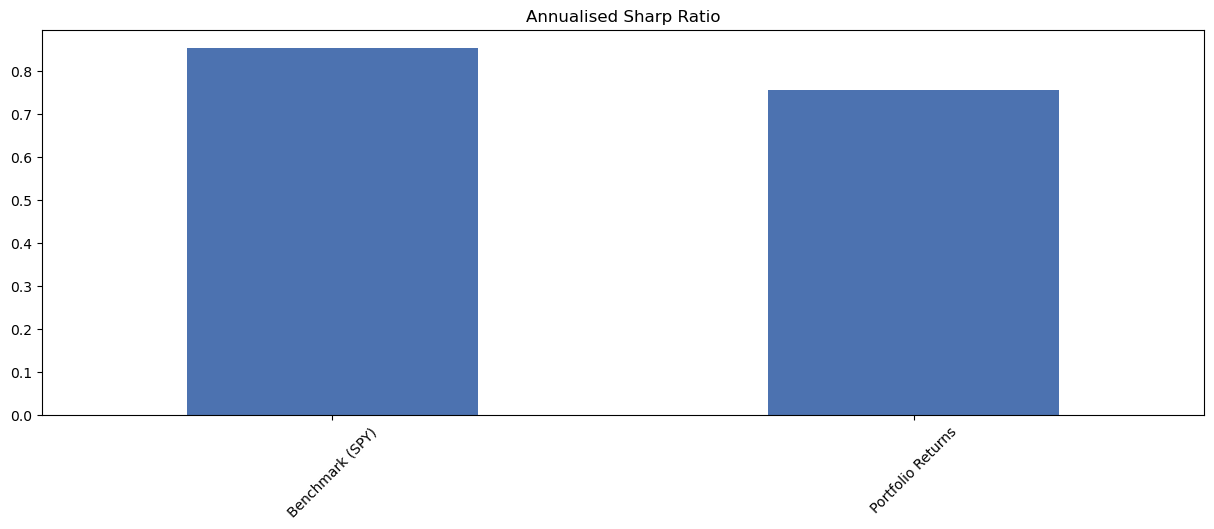

In [70]:
# Portfolio Sharp Ratio v Market Sharpratio
sharp_ratio = (covariance_df.mean()*252)/(covariance_df.std()*np.sqrt(252))
sharp_ratio.sort_values(ascending=False,inplace=True)
sharp_ratio.plot.bar(figsize=(15,5),title='Annualised Sharp Ratio', rot=45);

# Calculating accumulated returns

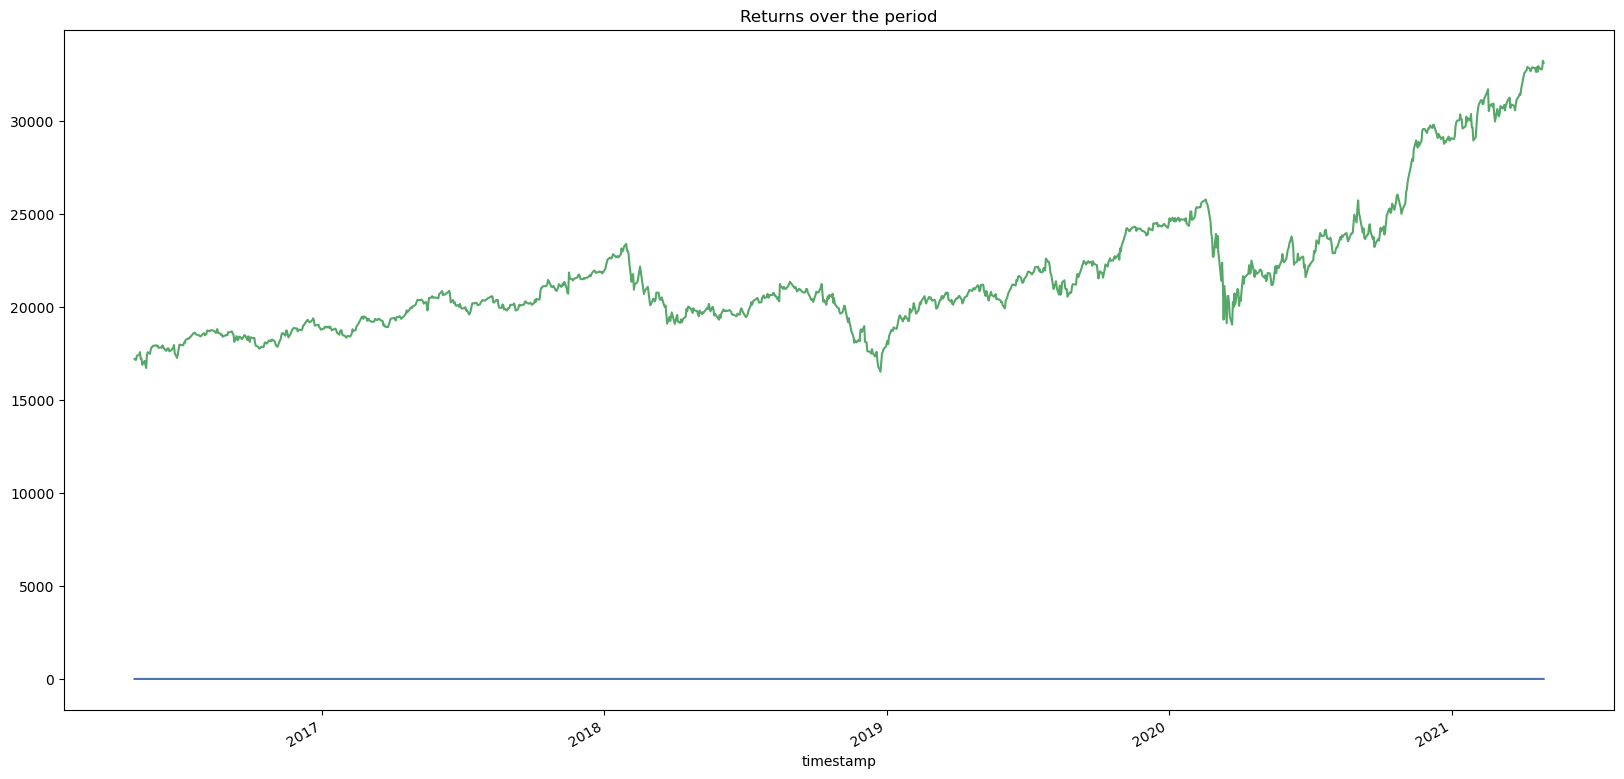

In [71]:
initial_investment = portfolio_current_stats["Purchase Value"].sum()

cumulative_return = (1+custom_port_daily_returns_dot).cumprod()
# Plot cumulative returns
cumulative_return.plot(figsize = (20,10), title= 'Historic Return');

cumulative_profits = initial_investment * cumulative_return
cumulative_profits.plot(figsize = (20,10), 
                          title= f'Returns over the period');
                                              

In [72]:
# ROI = (Current Value of Investment - Cost of Investment) / Cost of Investment
current_value = total_portfolio_value

roi = (current_value - initial_investment) / initial_investment
roi_pct = roi * 100
print(f"ROI for an initial investment of ${initial_investment:0.2f} "
      f"now priced at ${total_portfolio_value:0.2f} "
      f"is {roi:0.2f} or {roi_pct:0.2f}%")

ROI for an initial investment of $17370.72 now priced at $74820.00 is 3.31 or 330.72%
